In [1]:
from ROOT import TFile
from EventToGraph import rtfile_to_datalist, MyDataset
from torch_geometric.loader import DataLoader
from sklearn.utils import shuffle

Welcome to JupyROOT 6.22/02


In [2]:
f_sig = TFile.Open(
    "./SelectorOutput/2017/Skim1E2Mu__/Selector_TTToHcToWA_AToMuMu_MHc130_MA90.root"
)
f_bkg = TFile.Open(
    "./SelectorOutput/2017/Skim1E2Mu__/Selector_TTLL_powheg.root"
)


In [3]:
sig_datalist = rtfile_to_datalist(f_sig, is_signal=True)
bkg_datalist = rtfile_to_datalist(f_bkg, is_signal=False)
datalist = shuffle(sig_datalist + bkg_datalist)
train_dataset = MyDataset(datalist[:11000])
test_dataset = MyDataset(datalist[11000:])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [4]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, SELU, BatchNorm1d
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn import MessagePassing, GraphNorm
from torch_geometric.utils import add_self_loops, degree

num_features = train_dataset[0].num_node_features
num_classes = train_dataset.num_classes

class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max')
        self.mlp = Sequential(Linear(2*in_channels, out_channels),
                              BatchNorm1d(),
                              ReLU(),
                              Linear(out_channels, out_channels),
                              BatchNorm1d(),
                              ReLU(),
                              Linear(out_channels, out_channels))
    
    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j-x_i], dim=1)
        return self.mlp(tmp)
    
class ParticleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gn0 = GraphNorm(num_features)
        self.conv1 = EdgeConv(num_features, 256)
        self.gn1 = GraphNorm(256)
        self.conv2 = EdgeConv(256, 256)
        self.gn2 = GraphNorm(256)
        self.conv3 = EdgeConv(256, 256)
        self.fc1 = Linear(256, 64)
        self.classifier = Linear(64, num_classes)
        
    def forward(self, x, edge_index, batch):
        x = self.gn0(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.gn1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.gn2(x)
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, batch)
        x = self.fc1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.classifier(x)
        return F.softmax(x, dim=1)

model = ParticleNet()
print(model)

ParticleNet(
  (gn0): GraphNorm(9)
  (conv1): EdgeConv()
  (gn1): GraphNorm(256)
  (conv2): EdgeConv()
  (gn2): GraphNorm(256)
  (conv3): EdgeConv()
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = ParticleNet().to(DEVICE)
optimizer = torch.optim.Adadelta(model.parameters(), lr=0.2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    
    for data in train_loader:
        out = model(data.x.to(DEVICE), data.edge_index.to(DEVICE), data.batch.to(DEVICE))
        loss = criterion(out, data.y.to(DEVICE))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
        
def test(loader):
    model.eval()
    
    correct = 0
    for data in loader:
        out = model(data.x.to(DEVICE), data.edge_index.to(DEVICE), data.batch.to(DEVICE))
        pred = out.argmax(dim=1)
        correct += int((pred == data.y.to(DEVICE)).sum())
    return correct / len(loader.dataset)

In [11]:
train_scores = []
test_scores = []
for epoch in range(120):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_scores.append(train_acc)
    test_scores.append(test_acc)
    print(f'[EPOCH {epoch}]\tTrain Acc: {train_acc:.4f},\tTest Acc: {test_acc:.4f}')

[EPOCH 0]	Train Acc: 0.7640,	Test Acc: 0.7478
[EPOCH 1]	Train Acc: 0.7963,	Test Acc: 0.7824
[EPOCH 2]	Train Acc: 0.8035,	Test Acc: 0.7849
[EPOCH 3]	Train Acc: 0.8088,	Test Acc: 0.7979
[EPOCH 4]	Train Acc: 0.8037,	Test Acc: 0.7814
[EPOCH 5]	Train Acc: 0.8185,	Test Acc: 0.7981
[EPOCH 6]	Train Acc: 0.8166,	Test Acc: 0.7915
[EPOCH 7]	Train Acc: 0.8244,	Test Acc: 0.7994
[EPOCH 8]	Train Acc: 0.8195,	Test Acc: 0.7983
[EPOCH 9]	Train Acc: 0.8303,	Test Acc: 0.8062
[EPOCH 10]	Train Acc: 0.8399,	Test Acc: 0.8108
[EPOCH 11]	Train Acc: 0.8435,	Test Acc: 0.8155
[EPOCH 12]	Train Acc: 0.8536,	Test Acc: 0.8204
[EPOCH 13]	Train Acc: 0.8434,	Test Acc: 0.8062
[EPOCH 14]	Train Acc: 0.8538,	Test Acc: 0.8182
[EPOCH 15]	Train Acc: 0.8542,	Test Acc: 0.8176
[EPOCH 16]	Train Acc: 0.8581,	Test Acc: 0.8171
[EPOCH 17]	Train Acc: 0.8601,	Test Acc: 0.8186
[EPOCH 18]	Train Acc: 0.8692,	Test Acc: 0.8222
[EPOCH 19]	Train Acc: 0.8627,	Test Acc: 0.8143
[EPOCH 20]	Train Acc: 0.8659,	Test Acc: 0.8185
[EPOCH 21]	Train Acc: 0

KeyboardInterrupt: 

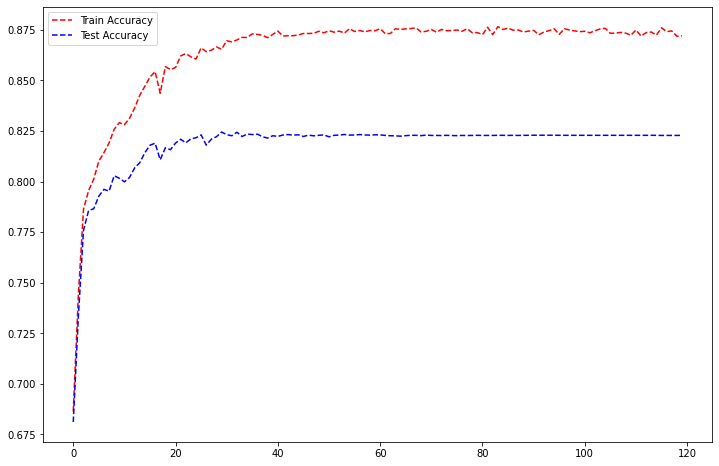

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(range(120), train_scores, 'r--', label='Train Accuracy')
plt.plot(range(120), test_scores, 'b--', label="Test Accuracy")
plt.legend(loc='best')
plt.show()